## Copy Paste Augmentation (experimental)

This is an attempt to get both types of objects in the same image.  Did not work as well as I had hoped as objects were not blended well....

(-0.5, 255.5, 255.5, -0.5)

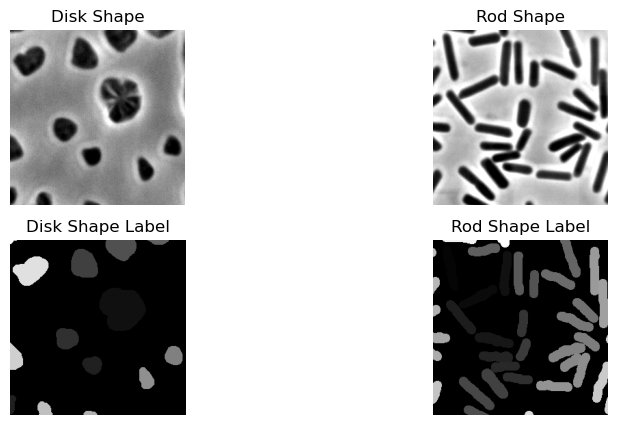

In [7]:
import os 
from skimage.io import imread
import matplotlib.pyplot as plt

parent_path = r'D:\images\tnia-python-images\imagesc\2025_04_12_rod_and_disk'
train_path = os.path.join(parent_path, 'patches')
img_train_path = os.path.join(train_path, 'input0')
label_train_path = os.path.join(train_path, 'ground truth0')
name1 = 'diskShape_000000.tif'
name2 = 'rodShape_000000.tif' 

img1 = imread(os.path.join(img_train_path, name1))
img2 = imread(os.path.join(img_train_path, name2))
lbl1 = imread(os.path.join(label_train_path, name1))
lbl2 = imread(os.path.join(label_train_path, name2))

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0,0].imshow(img1, cmap='gray')
ax[0,0].set_title('Disk Shape')
ax[0,0].axis('off')
ax[0,1].imshow(img2, cmap='gray')
ax[0,1].set_title('Rod Shape')
ax[0,1].axis('off')
ax[1,0].imshow(lbl1, cmap='gray')
ax[1,0].set_title('Disk Shape Label')
ax[1,0].axis('off')
ax[1,1].imshow(lbl2, cmap='gray')
ax[1,1].set_title('Rod Shape Label')
ax[1,1].axis('off')


In [8]:
from albumentations import Compose
from albumentations.contrib.transforms import CopyPaste

transform = Compose([
    CopyPaste(blend=True, sigma=1.0, pct_objects_paste=0.5)
])

# image1 and image2 are dicts with 'image' and 'mask' keys
result = transform(image=image1['image'], mask=image1['mask'],
                   image2=image2['image'], mask2=image2['mask'])

c:\Users\bnort\miniconda3\envs\sam\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'albumentations.contrib'

In [9]:
import numpy as np
import cv2

def copy_paste(image, mask, paste_image, paste_mask):
    # Find connected components in paste_mask
    num_objs, labels = cv2.connectedComponents(paste_mask.astype(np.uint8))

    out_image = image.copy()
    out_mask = mask.copy()

    for obj_id in range(1, num_objs):
        obj_mask = (labels == obj_id).astype(np.uint8)
        ys, xs = np.where(obj_mask)
        if len(xs) == 0 or len(ys) == 0:
            continue

        xmin, xmax = xs.min(), xs.max()
        ymin, ymax = ys.min(), ys.max()

        # Crop object
        obj_img_crop = paste_image[ymin:ymax+1, xmin:xmax+1]
        obj_mask_crop = obj_mask[ymin:ymax+1, xmin:xmax+1]

        # Random paste location
        h, w = image.shape[:2]
        new_x = np.random.randint(0, w - obj_img_crop.shape[1])
        new_y = np.random.randint(0, h - obj_img_crop.shape[0])

        # Paste object
        roi = out_image[new_y:new_y + obj_img_crop.shape[0], new_x:new_x + obj_img_crop.shape[1]]
        roi_mask = out_mask[new_y:new_y + obj_mask_crop.shape[0], new_x:new_x + obj_mask_crop.shape[1]]

        # Apply paste
        mask_bool = obj_mask_crop.astype(bool)
        roi[mask_bool] = obj_img_crop[mask_bool]
        roi_mask[mask_bool] = 1  # or object label

        out_image[new_y:new_y + obj_img_crop.shape[0], new_x:new_x + obj_img_crop.shape[1]] = roi
        out_mask[new_y:new_y + obj_mask_crop.shape[0], new_x:new_x + obj_mask_crop.shape[1]] = roi_mask

    return out_image, out_mask

(-0.5, 255.5, 255.5, -0.5)

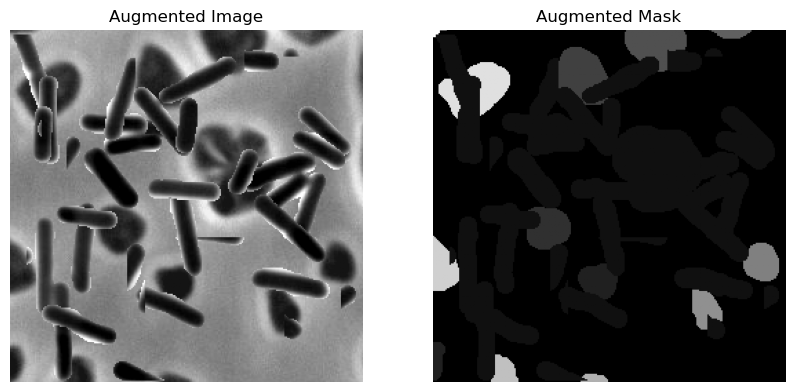

In [11]:
img_paste = np.zeros_like(img1)
lbl_paste = np.zeros_like(lbl1)

aug_img, aug_mask = copy_paste(img1, lbl1, img2, lbl2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(aug_img, cmap='gray')
ax[0].set_title('Augmented Image')
ax[0].axis('off')
ax[1].imshow(aug_mask, cmap='gray')
ax[1].set_title('Augmented Mask')
ax[1].axis('off')